## Датасет 1
https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam

Проблемная область: аналитика рынка видеоигр (в данном случае на площадке Steam)

Объект наблюдения: игры на площадке steam. Атрибутами являются характеристики игры (название, дата выпуска, цена, наличие игры на разных игровых платформах (пк, консоли)) и её оценка игроками (рейтинг, отзывы)
В данном датасете только 1 объект, но можно указать следующую связь: Игра связана со множеством отзывов

Бизнес-цель: Определить, как основные характеристики влияют на оценку игры steam, чтобы разработчики и издатели игр знали, во что следует вкладывать больше временных и денежных ресуров. Эффект для бизнеса: увеличение шансов на успех игры, снижение рисков финансовых потерь

Цель технического проекта: построить модель машинного обучения, которая предскажет, какую оценку от игроков получит игра.
Вход: дата выпуска игры (чтобы возможно найти закономерности между месяцем выпуска игры и её высокой оценкой), цена игры, наличие игры на windows, linux и mac. Целевой признак: рейтинг


In [296]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
df1 = pd.read_csv("..//static//csv//games.csv")

print(df1.columns)

Index(['app_id', 'title', 'date_release', 'win', 'mac', 'linux', 'rating',
       'positive_ratio', 'user_reviews', 'price_final', 'price_original',
       'discount', 'steam_deck'],
      dtype='object')


Оценка всех числовых признаков показывает, что в датасете довольно много выбросов. 

По столбцу positive_ratio есть игры, у которых очень мало позитивных отзывов, однако в случае игр важно знать и игры, у которых больше негативных отзывов, чем положительных, т.е. это полезный шум. Данные же смещены в сторону игр с бОльшим количеством положительных отзывов (более 60%), чем отрицательных. Однако данный столбец может влиять на столбец со строковыми значениями rating, поэтому в дальнейшем его можно считать просто шумом 

В столбце user_reviews есть серьёзный выброс с крайне большим количеством отзывов, однако сам столбец можно считать шумом, т.к. в данной ситуации количество отзывов не так важно, как рейтинг игры. 

Столбец price_final зависит от столбцов price_original и discount. В данном случае не стоит учитывать скидки на игры и их цену после скидки, поэтому столбцы price_final и discount можно считать шумом.

В столбце price_original есть много выбросов, которые находятся выше средних значений. Для анализа желательны разные цены игр, однако игры с ценами более 150$ можно удалить, т.к. вероятность настолько дорогой игры крайне мала и из-за таких игр модель может обучиться некорректно. Данные же в столбце смещены в сторону игр до 25$

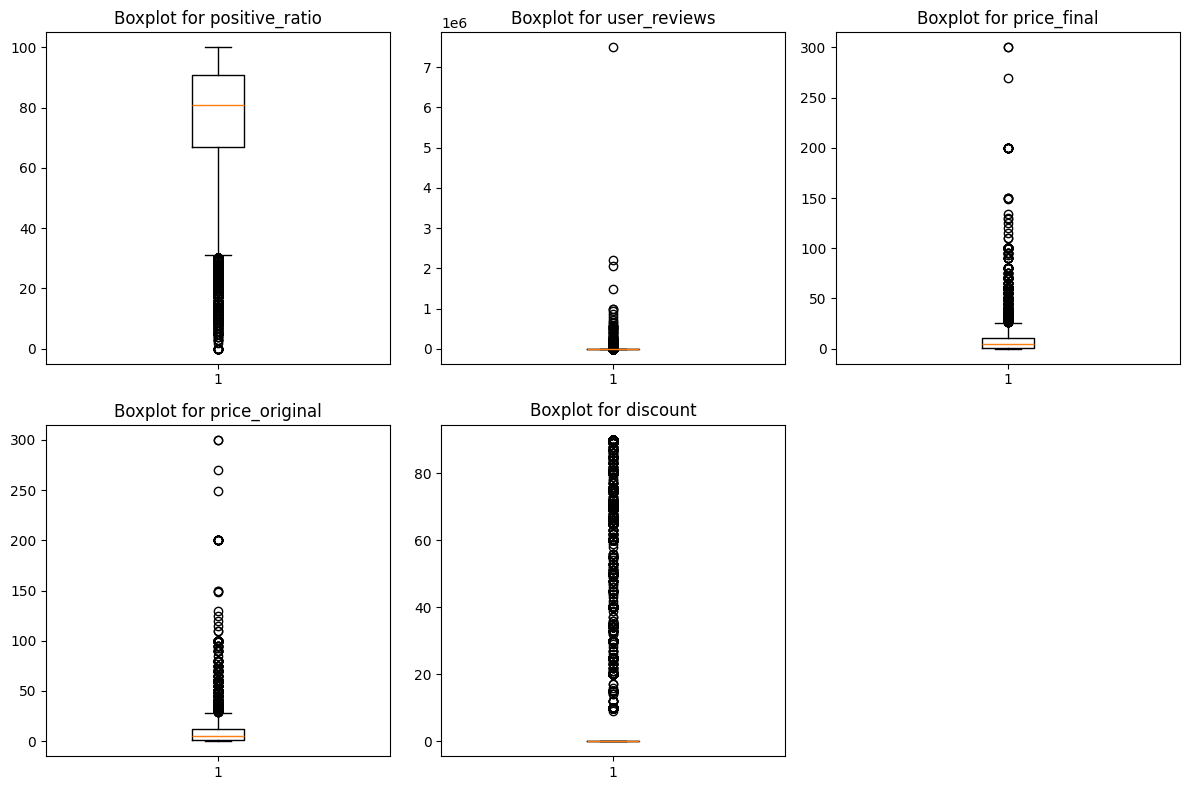

In [297]:
numeric_cols = df1.select_dtypes(include=['number']).columns

#все столбцы, кроме app_id
numeric_cols = [col for col in numeric_cols if col != 'app_id']

plt.figure(figsize=(12, 8))
   

for i, col in enumerate(numeric_cols, 1):
    if col == 'id':
        continue
    Q1 = df1[col].quantile(0.25)
    Q3 = df1[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df1[col][(df1[col] < lower_bound) | (df1[col] > upper_bound)]
    plt.subplot(len(numeric_cols) // 3 + 1, 3, i) 
    plt.boxplot(x=df1[col])
    plt.title(f'Boxplot for {col}')

plt.tight_layout()
plt.show()

Для проверки на просачивание данных, рейтинг игры, представленный в датасете в виде строковых значений, необходимо перевести в числовую шкалу. Было бы логично перевести игры в 5-бальную шкалу или 10-бальную, но всего разных строковых рейтингов 9, что не делится на 5 и 10. Поэтому для равномерного распределения строковых рейтингов они были переведены в 3-бальную шкалу. С этой шкалой сильно коррелирует только столбец с отношением положительных отзывов к отрицательным (positive_ratio), что логично, т.к. от этого столбца зависит столбец rating, на основе которого и был создан столбец rating_stars с 5-бальной шкалой. Однако признак positive_ratio не будет входным, поэтому просачивания данных не будет.

In [298]:
#просмотр того, какие рейтинги игр есть в таблице
print(df1['rating'].unique())

#преобразование строковых значений рейтинга в числовые оценки от 1 до 5
# rating_mapping = {'Overwhelmingly Positive': 5, 
#                   'Very Positive': 5, 
#                   'Positive': 4, 
#                   'Mostly Positive': 4, 
#                   'Mixed': 3, 
#                   'Mostly Negative': 3, 
#                   'Negative': 2, 
#                   'Very Negative': 2,
#                   'Overwhelmingly Negative': 1
#                   } 
# rating_mapping = {'Overwhelmingly Positive': 10, 
#                   'Very Positive': 9, 
#                   'Positive': 8, 
#                   'Mostly Positive': 7, 
#                   'Mixed': 6, 
#                   'Mostly Negative': 5, 
#                   'Negative': 4, 
#                   'Very Negative': 3,
#                   'Overwhelmingly Negative': 2
#                   } 
rating_mapping = {'Overwhelmingly Positive': 3, 
                  'Very Positive': 3, 
                  'Positive': 3, 
                  'Mostly Positive': 2, 
                  'Mixed': 2, 
                  'Mostly Negative': 2, 
                  'Negative': 1, 
                  'Very Negative': 1,
                  'Overwhelmingly Negative': 1
                  } 
df1['rating_stars'] = df1['rating'].map(rating_mapping)


#проверка кореляции (просачивания данных)
main_col = 'rating_stars'
for col1 in numeric_cols:
    if col1 != main_col:
        correlation = df1[col1].corr(df1[main_col])
        if abs(correlation) > 0.7:
            print(f"Просачивание данных: Высокая корреляция ({correlation:.2f}) между столбцами '{col1}' и '{main_col}'")

['Very Positive' 'Positive' 'Mixed' 'Mostly Positive'
 'Overwhelmingly Positive' 'Negative' 'Mostly Negative'
 'Overwhelmingly Negative' 'Very Negative']
Просачивание данных: Высокая корреляция (0.82) между столбцами 'positive_ratio' и 'rating_stars'


Данный датасет не совсем информативный, т.к. нет данных о жанре игры и об издателе, что вполне может повлиять на оценку игры. Тем не менее в нём есть данные об отзывах и оценке, дате выхода, цене и доступных платформах, что так же может влиять на оценку игры.

Покрытие у датасета хорошее, т.к. содержится 50000 записей об играх с 1997 по 2023 год, однако важных данных об играх текущего года здесь нет. Данные также могут быть неактуальны, т.к. с последней даты выхода игры прошёл год, за который отзывы на игры могли измениться. 

Метки согласованы, однако метку final_price можно принять за окончательную цену игры после её выпуска, что неверно, т.к. это на самом деле означает цену после применения скидки

In [299]:
print(df1.columns)
print(f"Количество записей: {df1.shape[0]}")
#даты выхода игр
df1['date_release'] = pd.to_datetime(df1['date_release'])
df_sorted = df1.sort_values(by='date_release')
print(df_sorted['date_release'].unique())

Index(['app_id', 'title', 'date_release', 'win', 'mac', 'linux', 'rating',
       'positive_ratio', 'user_reviews', 'price_final', 'price_original',
       'discount', 'steam_deck', 'rating_stars'],
      dtype='object')
Количество записей: 50872
<DatetimeArray>
['1997-06-30 00:00:00', '1997-11-14 00:00:00', '1998-11-08 00:00:00',
 '1999-04-01 00:00:00', '1999-09-08 00:00:00', '1999-11-01 00:00:00',
 '2000-11-01 00:00:00', '2001-06-01 00:00:00', '2002-08-28 00:00:00',
 '2003-05-01 00:00:00',
 ...
 '2023-10-12 00:00:00', '2023-10-13 00:00:00', '2023-10-15 00:00:00',
 '2023-10-16 00:00:00', '2023-10-17 00:00:00', '2023-10-18 00:00:00',
 '2023-10-19 00:00:00', '2023-10-20 00:00:00', '2023-10-23 00:00:00',
 '2023-10-24 00:00:00']
Length: 4292, dtype: datetime64[ns]


Во всех столбцах нет пропущенных данных, поэтому данную проблему устранять не надо

In [300]:
columns_with_nulls = []
for col in df1.columns:
  if df1[col].isnull().sum() > 0:  
    columns_with_nulls.append(col)
print(f"Cтолбцы, в которых пропущены значения: {columns_with_nulls}")

Cтолбцы, в которых пропущены значения: []


**РАЗБИЕНИЕ НА ВЫБОРКИ**

train_data - обучающая выборка

val_data - контрольная выборка

test_data - тестовая выборка

Заметно, что в обучающую выборку попало слишком мало игр с низким рейтингом. Необходимо прирастить данные для таких игр через oversampling 

Размер обучающей выборки: 40697
Размер контрольной выборки: 5087
Размер тестовой выборки: 5088


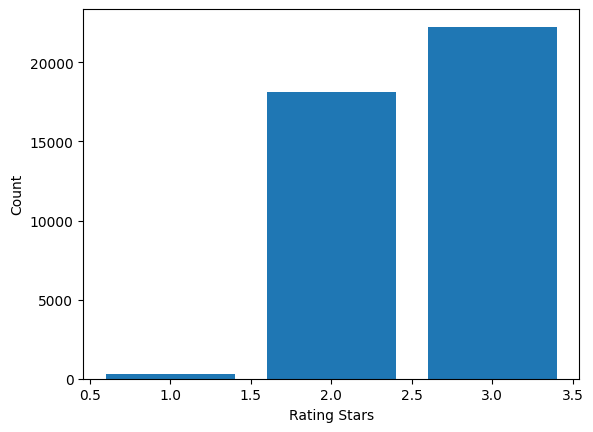

rating_stars
1      296
2    18144
3    22257
Name: count, dtype: int64


In [301]:
from sklearn.model_selection import train_test_split
data=df1[['date_release', 'win', 'linux', 'mac', 'price_original', 'rating_stars']].copy()
# сначала разделение записей на 80% и 20%, где 80% - обучающая выборка
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)

# потом разделение остальных 20% поровну на контрольную и тестовую выборки
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Проверка размеров выборок
print("Размер обучающей выборки:", len(train_data))
print("Размер контрольной выборки:", len(val_data))
print("Размер тестовой выборки:", len(test_data))


# построение столбчатой диаграммы по столбцу rating_stars (сбалансированность обучающей выборки)
rating_counts = train_data['rating_stars'].value_counts().sort_index()

plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel('Rating Stars')
plt.ylabel('Count')
plt.show()

print(train_data["rating_stars"].value_counts().sort_index())

**ПРИРАЩЕНИЕ ДАННЫХ (oversampling)**

После приращения данных по играм с отрицательными отзывами стало гораздо больше. Теперь распределение игр стало гораздо сбалансированнее

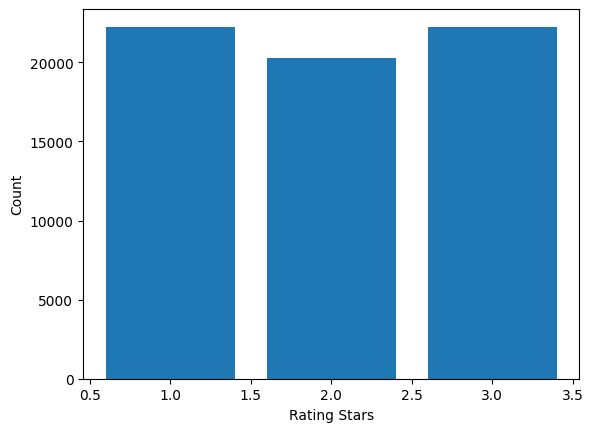

rating_stars
1    22234
2    20308
3    22257
Name: count, dtype: int64


In [302]:
from imblearn.over_sampling import ADASYN
ada = ADASYN(n_neighbors=3)
#ada = ADASYN()


#Преобразование нечисленных значений к численным для возиожности работы с oversampling
train_data['date_release'] = pd.to_datetime(df1['date_release']).astype('int64')/ 10**9
train_data['mac'] = train_data["mac"].astype(int)
train_data['win'] = train_data["mac"].astype(int)
train_data['linux'] = train_data["linux"].astype(int)

X_resampled, y_resampled = ada.fit_resample(train_data, train_data["rating_stars"])
train_data_adasyn = pd.DataFrame(X_resampled)


rating_counts_adasyn = train_data_adasyn['rating_stars'].value_counts().sort_index()

plt.bar(rating_counts_adasyn.index, rating_counts_adasyn.values)
plt.xlabel('Rating Stars')
plt.ylabel('Count')
plt.show()

print(train_data_adasyn["rating_stars"].value_counts().sort_index())

## **ДАТАСЕТ 2**

https://www.kaggle.com/datasets/dewangmoghe/mobile-phone-price-prediction


Проблемная область: рынок мобильных телефонов

Объекты наблюдения: мобильные телефоны

Атрибуты объектов:
* Name: Название

* Rating: оценка телефона (от 0 до 5).

* Spec_score: оценка телефона на основе его основных характеристик (от 0 до 100)

* No_of_sim: поддерживает ли телефон две SIM-карты, 3G, 4G, 5G, Volte

* RAM: кол-во оперативной памяти

* Battery: хар-ки аккумулятора

* Display: размере экрана телефона

* Camera: хар-ки передней и задней камерах

* External_Memory: поддерживает ли внешнюю память и сколько

* Android_version: версия Android телефона

* Price: цена

* Company: компания, которой принадлежит телефон

* Inbuilt_memory: встроенная память телефона

* fast_charging: поддерживает ли быструю зарядку или нет и насколько ватт.

* Screen_resolution: разрешение экрана

* Processor: описание процессора

* Processor_name: название процессора

Связи между объектами:
Между ценой телефона и его другими хар-ками (чем лучше хар-ки, тем дороже должен быть телефон)

Бизнес-цель: помочь производителям и продавцам определить оптимальную цену для новых телефонов на основе конкурентов.
Эффект для бизнеса: Улучшение конкурентоспособности на рынке, потенциальное увеличение прибыли

Цель технического проекта: создать модель машинного обучения, которая будет предсказывать цену мобильного телефона на основе его характеристик.
Входные данные: Характеристики мобильных телефонов (хар-ки аккумулятора, камеры, процессор и т.д.).
Целевой признак: цена

In [303]:
df2 = pd.read_csv("..//static//csv//mobiles.csv")
print(df2.columns)
print(df2.info())

Index(['Unnamed: 0', 'Name', 'Rating', 'Spec_score', 'No_of_sim', 'Ram',
       'Battery', 'Display', 'Camera', 'External_Memory', 'Android_version',
       'Price', 'company', 'Inbuilt_memory', 'fast_charging',
       'Screen_resolution', 'Processor', 'Processor_name'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1370 entries, 0 to 1369
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1370 non-null   int64  
 1   Name               1370 non-null   object 
 2   Rating             1370 non-null   float64
 3   Spec_score         1370 non-null   int64  
 4   No_of_sim          1370 non-null   object 
 5   Ram                1370 non-null   object 
 6   Battery            1370 non-null   object 
 7   Display            1370 non-null   object 
 8   Camera             1370 non-null   object 
 9   External_Memory    1370 non-null   object 
 10  Android_version   

В столбце Ram есть шум в виде значений, которые явно не относятся к значению оперативной памяти ('Helio G90T', '128 GB inbuilt' '6000 mAh Battery with 22.5W Fast Charging'
'256 GB inbuilt' '512 GB inbuilt'). Строки с этими значениями можно удалить, т.к. у них значения съехали с других столбцов, а значит и в другом столбце будет неверное значение. 

Также было обнаружено, что не все цены указаны верно, т.к. у некоторых значений было 2 запятые. Для преобразования значений в числа запятые были заменены на точки, а в строках, где стало 2 точки, первая точка удалена.

Актуальность данных проверить нельзя, т.к. в датасете нет даты релиза смартфона

Покрытие данных очень хорошее, т.к. представлено большое количество смартфон разной ценовой категории

In [304]:
for col in df2.columns:
  print(df2[col].unique())

#Преобразование категориальных данных в числа
#Удаление подстроки 'GB RAM', чтобы остались только числа
df2['Ram'] = df2['Ram'].replace(' GB RAM', '', regex=True)

import re
# Удаление строк, у кот. в Ram какое-то неверное значение (оставление только строк, где число)
df2 = df2[df2['Ram'].apply(lambda x: bool(re.match(r'^\d+(\.\d+)?$', str(x))))]

#Исправление батареи. Удаление подстроки 'mAh Battery', чтобы остались только числа
df2['Battery'] = df2['Battery'].replace(' mAh Battery', '', regex=True)

#Исправление диагонали. Удаление подстроки 'inches'
df2['Display'] = df2['Display'].replace(' inches', '', regex=True)

#Исправление встроенной памяти на числа
df2['Inbuilt_memory'] = df2['Inbuilt_memory'].replace(' GB inbuilt', '', regex=True)
df2['Inbuilt_memory'] = df2['Inbuilt_memory'].replace('TB inbuilt', '024', regex=True)
df2['Inbuilt_memory'] = df2['Inbuilt_memory'].replace(' ', '', regex=True)

[   0    1    2 ... 1367 1368 1369]
['Samsung Galaxy F14 5G' 'Samsung Galaxy A11' 'Samsung Galaxy A13' ...
 'TCL 50 XE NxtPaper 5G' 'TCL 40 NxtPaper 5G' 'TCL Trifold']
[4.65 4.2  4.3  4.1  4.4  4.05 4.5  4.25 4.75 4.15 4.35 4.45 4.6  4.
 4.55 4.7  3.95 3.75 3.9  3.85]
[68 63 75 73 69 76 71 85 78 72 74 79 80 62 81 82 87 86 88 84 83 89 91 90
 96 93 92 95 65 59 42 67 60 61 54 66 70 51 64 53 77 94 98 97 58 57 49 46
 56 55]
['Dual Sim, 3G, 4G, 5G, VoLTE, ' 'Dual Sim, 3G, 4G, VoLTE, '
 'Dual Sim, 3G, 4G, 5G, VoLTE, Vo5G, ' 'Single Sim, 3G, 4G, 5G, VoLTE, '
 'Dual Sim, 3G, 4G, ' 'Single Sim, 3G, 4G, VoLTE, ' 'No Sim Supported, '
 'Single Sim, 3G, 4G, 5G, VoLTE, Vo5G, ' 'Dual Sim, 3G, VoLTE, ']
['4 GB RAM' '2 GB RAM' '6 GB RAM' '8 GB RAM' '12 GB RAM' '1 GB RAM'
 '3 GB RAM' '16 GB RAM' 'Helio G90T' '24 GB RAM' '18 GB RAM' '1.5 GB RAM'
 '128 GB inbuilt' '6000 mAh Battery with 22.5W Fast Charging'
 '256 GB inbuilt' '512 GB inbuilt']
['6000 mAh Battery ' '4000 mAh Battery ' '5000 mAh Battery '
 '6

In [305]:
# Проверка количества запятых в каждой строке
df2['comma_count'] = df2['Price'].apply(lambda x: x.count(','))
# Удаление строк, где больше одной запятой
df2 = df2[df2['comma_count'] <= 1]
# Удаление вспомогательного столбца
df2 = df2.drop(columns=['comma_count'])
df2['Price'] = df2['Price'].replace(',', '.', regex=True)


df2['Price'] = pd.to_numeric(df2['Price'], errors='coerce')

По boxplotам видно, что данные о телефонах смещены в сторону недорогих телефонов до 40 долларов с экранами до 7 дюймов и встроенной памятью до 256 Гб.


По цене и диагонали экрана много данных, находящихся вне основной массе, но в данном случае это является полезным шумом. По мощности батареи выбросы можно считать вредным шумом

Выбросы в столбце 'Ram':
1        2.0
39      12.0
49      12.0
54      12.0
65      12.0
        ... 
1312    12.0
1344     2.0
1346     2.0
1348     2.0
1351     2.0
Name: Ram, Length: 267, dtype: float64

Выбросы в столбце 'Battery':
0       6000
1       4000
3       6000
6       6000
9       6000
        ... 
1344    3000
1346    3000
1349    3000
1350    3000
1364    4000
Name: Battery, Length: 296, dtype: int64

Выбросы в столбце 'Display':
15       6.10
21       6.21
53       6.10
64       6.10
65       6.10
72       7.45
74       6.20
75       6.20
91       4.50
122      5.20
125      5.50
197      8.03
208      7.80
391      7.10
393      7.10
538     12.10
571      7.20
597      7.71
600      7.92
606      7.80
627      7.80
628      5.60
629      5.70
631      6.10
632      6.14
635      6.10
636      6.03
637      6.10
639      6.20
640      6.20
641      6.20
643      6.10
662      5.90
663      5.90
665      5.92
669      6.00
687      6.09
688      5.20
689      6.09
690

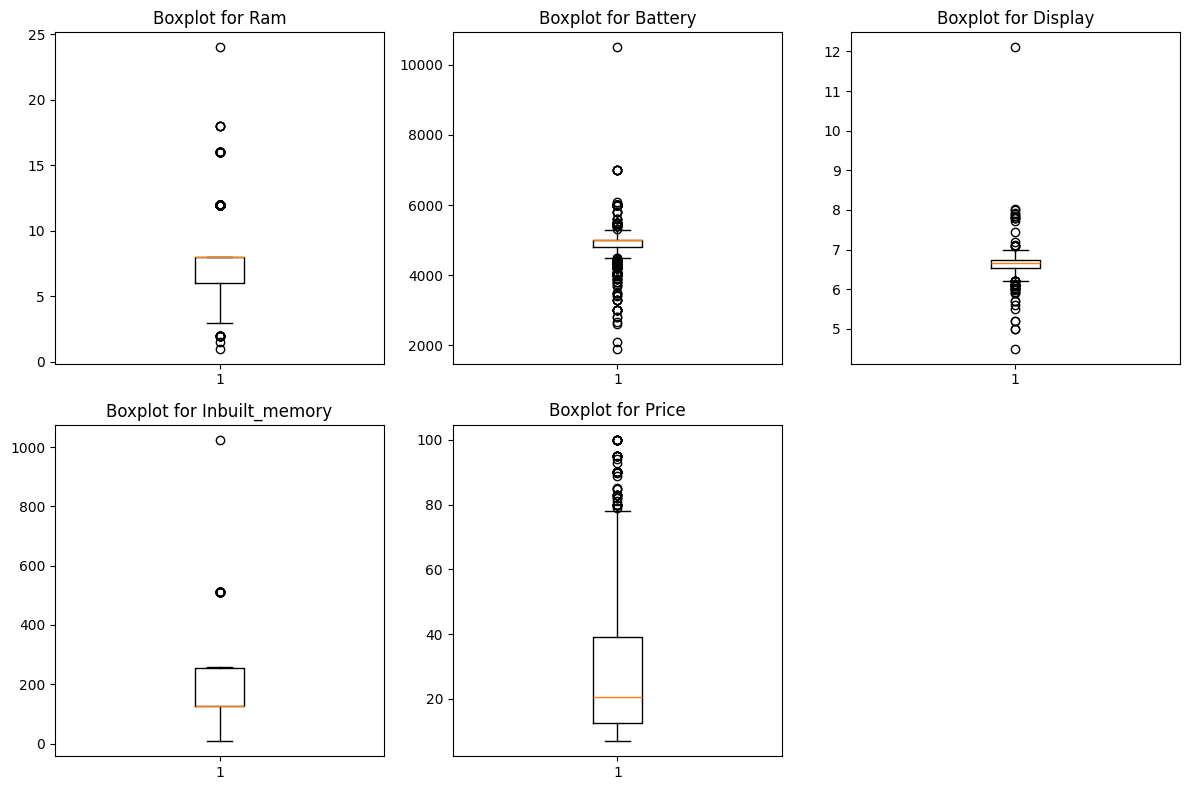

In [306]:
df2['Ram'] = pd.to_numeric(df2['Ram'])
df2['Battery'] = pd.to_numeric(df2['Battery'])
df2['Display'] = pd.to_numeric(df2['Display'])
df2['Inbuilt_memory'] = pd.to_numeric(df2['Inbuilt_memory'])

numeric_cols = df2[['Ram', 'Battery', 'Display', 'Inbuilt_memory', 'Price']].columns

numeric_cols = [col for col in numeric_cols]

plt.figure(figsize=(12, 8))
   

for i, col in enumerate(numeric_cols, 1):
    if col == 'id':
        continue
    Q1 = df2[col].quantile(0.25)
    Q3 = df2[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df2[col][(df2[col] < lower_bound) | (df2[col] > upper_bound)]
    print(f"Выбросы в столбце '{col}':\n{outliers}\n")
    plt.subplot(len(numeric_cols) // 3 + 1, 3, i) 
    plt.boxplot(x=df2[col])
    plt.title(f'Boxplot for {col}')

plt.tight_layout()
plt.show()

Просачивания данных нет, т.к. никакой столбец не коррелирует с целевым признаком более, чем на 0,7

In [307]:
#Проверка кореляции
price_col = 'Price'  # Имя столбца с ценой
for col1 in numeric_cols:
    if col1 != price_col:
        correlation = df2[col1].corr(df2[price_col])
        if abs(correlation) > 0.7:
            print(f"Просачивание данных: Высокая корреляция ({correlation:.2f}) между столбцами '{col1}' и '{price_col}'")

Пропущенные значения есть в 3-х столбцах. Для этих столбцов возможно только задать какое-то константное значение, например "Unknown"

In [308]:
# Проверка наличия пропущенных значений
columns_with_nulls = []
for col in df2.columns:
  if df2[col].isnull().sum() > 0:  
    columns_with_nulls.append(col)
print(f"Столбцы с null: {columns_with_nulls}")

# Замена значений null на "Unknown" в столбцах с пропусками
for col in columns_with_nulls:
    df2[col].fillna("Unknown", inplace=True)

Столбцы с null: ['Android_version', 'fast_charging', 'Processor']


C:\Users\ujijrujijr\AppData\Local\Temp\ipykernel_10056\2788500696.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2[col].fillna("Unknown", inplace=True)


**РАЗБИЕНИЕ НА ВЫБОРКИ**

Обучающая выборка сбалансрована, т.к. график идёт достаточно ровно и нет "перекоса" количества телефонов в каком-то диапазоне цен. Поэтому аугментация данных не требуется 

Размер обучающей выборки: 1035
Размер контрольной выборки: 129
Размер тестовой выборки: 130


Text(0.5, 1.0, 'Отсортированные цены в обучающей выборке')

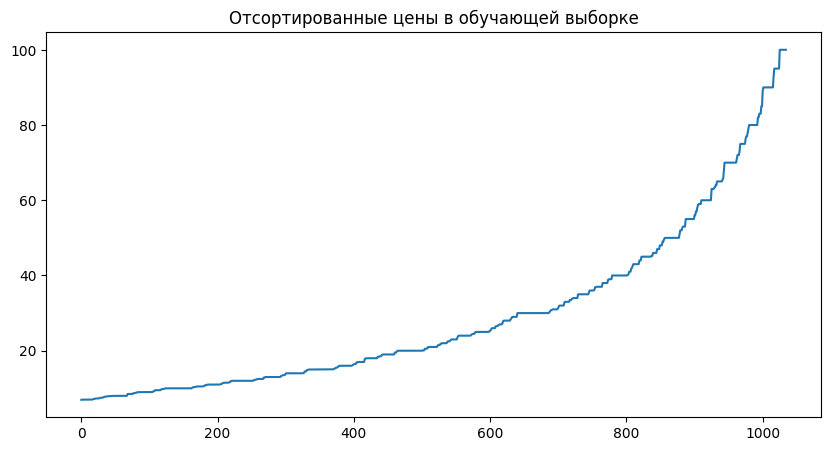

In [309]:
data=df2[['Ram', 'Battery', 'Display','Price', 'Inbuilt_memory']].copy()
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')
# сначала разделение записей на 80% и 20%, где 80% - обучающая выборка
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)

# потом разделение остальных 20% поровну на контрольную и тестовую выборки
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Проверка размеров выборок
print("Размер обучающей выборки:", len(train_data))
print("Размер контрольной выборки:", len(val_data))
print("Размер тестовой выборки:", len(test_data))


sort_train_data=train_data.sort_values(by='Price')['Price'].values
plt.figure(figsize=(10, 5))
plt.plot(sort_train_data)
plt.title('Отсортированные цены в обучающей выборке')

## **ДАТАСЕТ 3**

https://www.kaggle.com/datasets/shivam2503/diamonds

Проблемная оласть: цены на бриллианты

Объект наблюдения: бриллиант

Атрибуты:
* carat: Вес в каратах
* cut: Качество огранки
* color: Цвет
* clarity: Чистота
* depth: Процент глубины 
* table: Процент ширины
* price: Цена в долларах
* x: Длина в миллиметрах
* y: Ширина в миллиметрах
* z: Глубина в миллиметрах

Объект только 1, но в нём есть связь между ценой и всеми остальными характеристиками (чем лучше какая-либо характеристика, тем дороже бриллиант)

Бизнес-цель: Предсказать оптимальную стоимость бриллианта на основе его характеристик. Эффект для бизнеса: ювелиры смогут предлагать конкурентоспособные цены, что потенциально увеличить прибыль. 

Цель технического проекта: Построить модель машинного обучения для прогнозирования цены бриллианта на основе его характеристик. Вход: характеристики бриллианта (вес, огранка, цвет, чистота, размеры). Целевой признак: цена

In [290]:
df3 = pd.read_csv("..//static//csv//diamonds.csv")
print(df3.columns)

Index(['Unnamed: 0', 'carat', 'cut', 'color', 'clarity', 'depth', 'table',
       'price', 'x', 'y', 'z'],
      dtype='object')


Оценка всех числовых признаков показывает, что в датасете довольно много шума. В большинстве своём он полезные, т.к. бриллианты могут иметь абсолютно разные значения характеристик, и их важно учитывать. Однако есть одиночные выбросы, из-за которых модель может некорректно обучиться. Это данные, у которых значение:
* по параметру table больше 90
* по параметру x около 0
* по параметру y значение более 30 и около 0
* по параметру z значение более 30

Имеет смысл удалить данные выбросы.

Большинство данных смещено в следующую сторону:
* меньше 3 карат
* по проценту глубины между 50 и 70
* по проценту ширины между 50 и 60
* по длине между 4 и 9 мм
* по ширине между 5 и 10 мм
* по глубине между 2 и 5 мм 

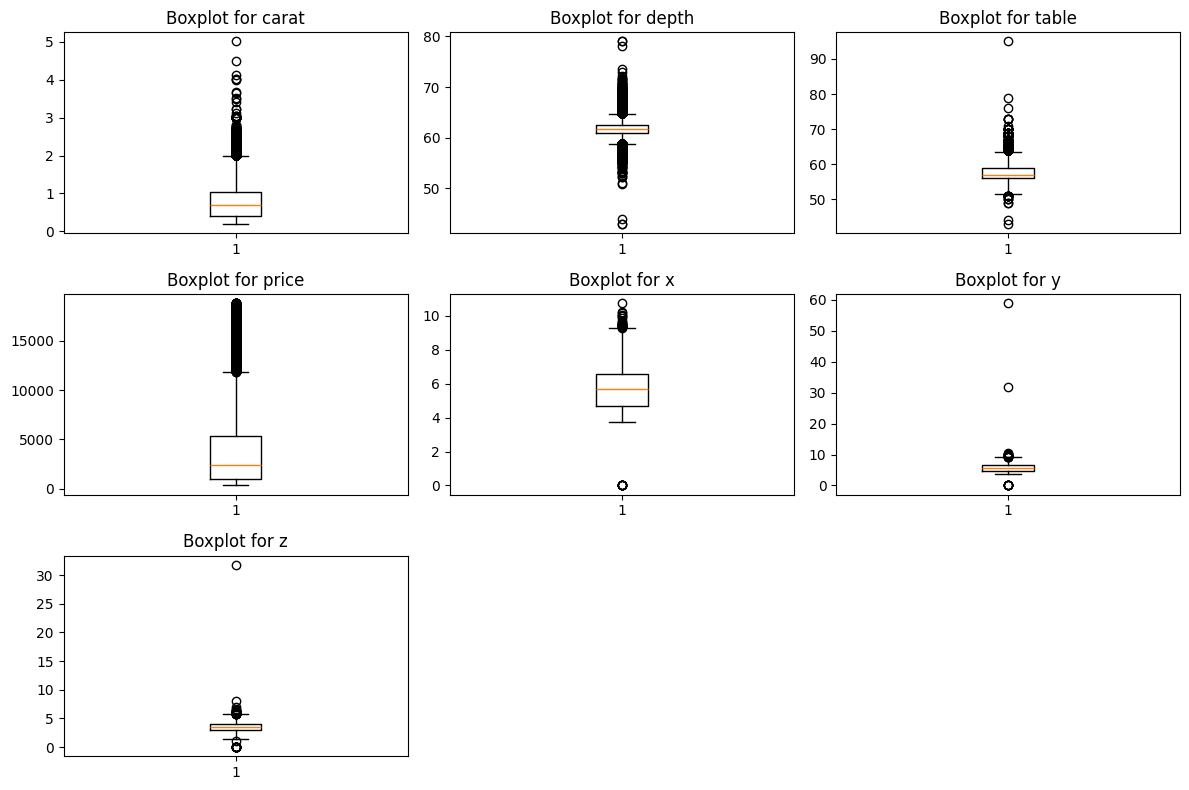

In [291]:
numeric_cols = df3.select_dtypes(include=['number']).columns

#все столбцы, кроме Unnamed (с индексом)
numeric_cols = [col for col in numeric_cols if 'Unnamed' not in col]

# столбец 'id' также исключен
numeric_cols = [col for col in numeric_cols if col != 'id']

plt.figure(figsize=(12, 8))
   

for i, col in enumerate(numeric_cols, 1):
    if col == 'id':
        continue
    Q1 = df3[col].quantile(0.25)
    Q3 = df3[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df3[col][(df3[col] < lower_bound) | (df3[col] > upper_bound)]
    plt.subplot(len(numeric_cols) // 3 + 1, 3, i) 
    plt.boxplot(x=df3[col])
    plt.title(f'Boxplot for {col}')

plt.tight_layout()
plt.show()

По числовым данным видно, что цена имеет прямую зависимость от веса и размеров бриллианта. Такая корреляции между столбцами carat, x, y, z и price является естественной и ожидаемой, так как чем больше бриллиант, тем он дороже

In [292]:
#Проверка кореляции

price_col = 'price'  # Имя столбца с ценой
for col1 in numeric_cols:
    if col1 != price_col:
        correlation = df3[col1].corr(df3[price_col])
        if abs(correlation) > 0.7:
            print(f"Просачивание данных: Высокая корреляция ({correlation:.2f}) между столбцами '{col1}' и '{price_col}'")

Просачивание данных: Высокая корреляция (0.92) между столбцами 'carat' и 'price'
Просачивание данных: Высокая корреляция (0.88) между столбцами 'x' и 'price'
Просачивание данных: Высокая корреляция (0.87) между столбцами 'y' и 'price'
Просачивание данных: Высокая корреляция (0.86) между столбцами 'z' и 'price'


Набор данных информативный, т.к. содержит основные характеристики бриллиантов, которые влияют на их цену

Степень покрытия высокая, т.к. содержатся сведения о более 50000 бриллиантах

Все метки согласованы, но 'depth' и 'x', 'y', 'z' могли быть названы немного подробнее

In [293]:
print(f"Количество записей: {df3.shape[0]}")

Количество записей: 53940


Столбцов со значениями null нет, поэтому решать проблему пропущенных данных не надо

In [294]:
columns_with_nulls = []
for col in df3.columns:
  if df3[col].isnull().sum() > 0:  
    columns_with_nulls.append(col)
print(f"Столбцы с null: {columns_with_nulls}")

Столбцы с null: []


**РАЗБИЕНИЕ НА ВЫБОРКИ**

train_data - обучающая выборка

val_data - контрольная выборка

test_data - тестовая выборка

Обучающая выборка сбалансрована, т.к. график идёт достаточно ровно и нет "перекоса" количества бриллиантов в каком-то диапазоне цен. Поэтому аугментация данных не требуется 

['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']
['E' 'I' 'J' 'H' 'F' 'G' 'D']
['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']
Размер обучающей выборки: 43152
Размер контрольной выборки: 5394
Размер тестовой выборки: 5394


Text(0.5, 1.0, 'Отсортированные цены в обучающей выборке')

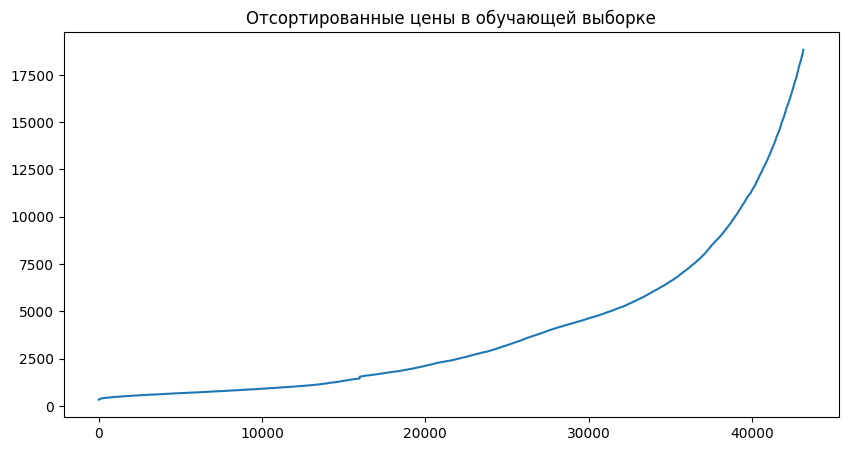

In [295]:
#приведение категориальных данных в числовые
print(df3['cut'].unique())
cut_mapping = {'Fair': 1, 
               'Good': 2, 
               'Very Good': 3, 
               'Premium': 4, 
               'Ideal': 5}
df3['cut'] = df3['cut'].map(cut_mapping)

print(df3['color'].unique())
color_mapping = {'D': 1, 
                 'E': 2, 
                 'F': 3, 
                 'G': 4, 
                 'H': 5, 
                 'I': 6, 
                 'J': 7} 
df3['color'] = df3['color'].map(color_mapping)


print(df3['clarity'].unique())
clarity_mapping = {
    'IF': 1, 
    'VVS1': 2, 
    'VVS2': 3, 
    'VS1': 4, 
    'VS2': 5, 
    'SI1': 6, 
    'SI2': 7, 
    'I1': 8} 
df3['clarity'] = df3['clarity'].map(clarity_mapping)



data=df3.copy()


# сначала разделение записей на 80% и 20%, где 80% - обучающая выборка
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)

# потом разделение остальных 20% поровну на контрольную и тестовую выборки
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Проверка размеров выборок
print("Размер обучающей выборки:", len(train_data))
print("Размер контрольной выборки:", len(val_data))
print("Размер тестовой выборки:", len(test_data))


sort_train_data=train_data.sort_values(by='price')['price'].values
plt.figure(figsize=(10, 5))
plt.plot(sort_train_data)
plt.title('Отсортированные цены в обучающей выборке')